In [63]:
from datetime import datetime, timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import xgboost as xgb
import cbpro

sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)

sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)
import requests
from creds import api_key

import tensorflow as tf
import tensorflow_probability as tfp
from pandasgui import show
public_client = cbpro.PublicClient()
tf.distribute.OneDeviceStrategy(device="/gpu:0")

In [5]:
def compile_lc_data(num_days=180, read_csv=False, write_csv=False, coins="ETH"):
    file = Path.cwd() / "lunar_histdata.csv"
    if read_csv is True:
        df = pd.read_csv(file, index_col=0)
        return df
    intervals = ["1d", "1w", "1m", "3m", "6m", "1y", "2y"]
    finish = datetime.now()
    start = finish - timedelta(days=num_days)
    delta = timedelta(hours=720)
    df = pd.DataFrame()
    while finish > start:
        payload = {
            "key": api_key,
            "symbol": coins,
            "change": intervals,
            "data_points": "720",
            "start": datetime.timestamp(start),
        }

        r = requests.get("https://api.lunarcrush.com/v2?data=assets", params=payload)

        data = pd.DataFrame.from_dict(r.json()["data"][0])
        ts = data.timeSeries.to_dict()
        new = pd.DataFrame.from_dict(ts, orient="index")
        new.pop("asset_id")
        new.pop("search_average")
        new["time"] = pd.to_datetime(new["time"], unit="s")
        new.set_index("time", inplace=True)
        new.sort_index(ascending=True, inplace=True)
        new["month"] = [new.index[i].month for i in range(len(new))]
        new["day"] = [new.index[i].day for i in range(len(new))]
        new["hour"] = [new.index[i].hour for i in range(len(new))]
        new.fillna(new.mean(), inplace=True)

        df = df.append(new, ignore_index=False, verify_integrity=True)
        start = start + delta

    if write_csv is True:
        df.to_csv(file)

    return df


df = compile_lc_data(read_csv=True)
print("NaN Check ")
print(df.isna().sum().sum())
print(df.index.max())
print(df.index.min())
print(len(df))
df.tail()


NaN Check 
0
2021-11-01 22:00:00
2021-05-05 23:00:00
4320


,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,...,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,percent_change_24h,month,day,hour
time,,,,,,,,,,,,,,,,,,,,,
2021-11-01 18:00:00,4288.824999,4300.061089,4305.435206,4268.149743,8.965711e+08,507892869753,1010,478,36.294221,416.41331,...,5466,0.070828,107741,5.073278,2826807582224,17.967012,0.989633,11,1,18
2021-11-01 19:00:00,4298.335304,4367.043910,4367.043910,4293.927685,1.194672e+09,514535193019,1347,488,36.294221,416.41331,...,4728,0.070902,97070,4.870712,2863827397137,17.966697,2.584965,11,1,19
2021-11-01 20:00:00,4368.342532,4314.745261,4368.342532,4308.580803,1.134377e+09,509534958369,804,484,36.294221,416.41331,...,4522,0.070911,95074,4.756295,2838648589938,17.949913,0.956078,11,1,20
2021-11-01 21:00:00,4314.089782,4301.825966,4314.089782,4287.239271,1.018351e+09,508822240531,584,350,36.294221,416.41331,...,4184,0.070641,89906,4.653749,2837770957426,17.930349,-0.265355,11,1,21
2021-11-01 22:00:00,4302.722841,4327.798225,4328.648152,4302.722841,4.247608e+08,511416658137,558,289,36.294221,416.41331,...,4100,0.070635,83667,4.900379,2848268822315,17.955351,0.630000,11,1,22


In [6]:
train_ds = df.sample(frac=0.8, random_state=0)
test_ds = df.drop(train_ds.index)

train_features = train_ds.copy()
test_features = test_ds.copy()

train_label = train_features.pop("close")
test_label = test_features.pop("close")


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features).astype("float32"))

linear_model = tf.keras.models.Sequential([normalizer, tf.keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam()

linear_model.compile(optimizer=optimizer, loss="mse")


In [15]:
test_results = {}


In [7]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(58, 1) dtype=float32, numpy=
array([[-0.11063595],
       [-0.2192051 ],
       [ 0.12995219],
       [ 0.3182317 ],
       [ 0.12560096],
       [ 0.24365234],
       [ 0.09808806],
       [-0.28830677],
       [-0.31554833],
       [ 0.00550181],
       [ 0.23695403],
       [-0.10895309],
       [ 0.10075805],
       [ 0.08154428],
       [ 0.24988389],
       [ 0.02311534],
       [-0.2507493 ],
       [ 0.19199717],
       [ 0.15866843],
       [ 0.08216241],
       [ 0.08306596],
       [-0.01467812],
       [-0.18077227],
       [-0.01752123],
       [-0.069914  ],
       [ 0.01843655],
       [ 0.20364213],
       [-0.04750642],
       [ 0.11162338],
       [-0.1393011 ],
       [-0.14247987],
       [-0.01605597],
       [-0.12424669],
       [-0.27227417],
       [ 0.18164665],
       [ 0.20481002],
       [-0.18948258],
       [-0.07387277],
       [ 0.25736916],
       [ 0.25031716],
       [-0.0982697 ],
       [ 0.17297933],
       [-0

In [14]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4, mode="min"
    )
history = linear_model.fit(
    train_features,
    train_label,
    epochs=200,
    validation_split=.2,
    callbacks=[early_stopping],
    
)

Epoch 1/200
87/87 [==============================] - 1s 4ms/step - loss: 9288545.0000 - val_loss: 9435410.0000
Epoch 2/200
87/87 [==============================] - 0s 3ms/step - loss: 9287249.0000 - val_loss: 9434096.0000
Epoch 3/200
87/87 [==============================] - 0s 2ms/step - loss: 9285970.0000 - val_loss: 9432758.0000
Epoch 4/200
87/87 [==============================] - 0s 3ms/step - loss: 9284684.0000 - val_loss: 9431385.0000
Epoch 5/200
87/87 [==============================] - 1s 6ms/step - loss: 9283396.0000 - val_loss: 9430074.0000
Epoch 6/200
87/87 [==============================] - 0s 3ms/step - loss: 9282112.0000 - val_loss: 9428717.0000
Epoch 7/200
87/87 [==============================] - 0s 2ms/step - loss: 9280822.0000 - val_loss: 9427395.0000
Epoch 8/200
87/87 [==============================] - 0s 2ms/step - loss: 9279545.0000 - val_loss: 9426066.0000
Epoch 9/200
87/87 [==============================] - 0s 3ms/step - loss: 9278251.0000 - val_loss: 9424739.0000
E

KeyboardInterrupt: 

In [ ]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()


,loss,val_loss,epoch
1995,7674121.5,7718907.0,1995
1996,7673610.0,7718395.5,1996
1997,7673098.5,7717897.5,1997
1998,7672584.5,7717384.0,1998
1999,7672078.5,7716883.5,1999


In [ ]:
test_results["linear_baseline"] = linear_model.evaluate(
    test_features, test_label, verbose=0
)


In [9]:
def build_and_compile_model(norm):
    model = tf.keras.models.Sequential(
        [
            norm,
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1),
        ]
    )
    model.compile(
        loss="mse", optimizer="adam", metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model


In [10]:
dnn_model = build_and_compile_model(normalizer)

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 58)                117       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3776      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,118
Trainable params: 8,001
Non-trainable params: 117
_________________________________________________________________


In [11]:
%%time
history = dnn_model.fit(
    train_features,
    train_label,
    validation_split=0.2,
    epochs=2000, callbacks=[early_stopping])

Epoch 1/2000
87/87 [==============================] - 1s 7ms/step - loss: 9224480.0000 - mean_absolute_error: 2957.4751 - val_loss: 9143555.0000 - val_mean_absolute_error: 2946.9038
Epoch 2/2000
87/87 [==============================] - 0s 4ms/step - loss: 8156817.0000 - mean_absolute_error: 2776.2710 - val_loss: 6991764.0000 - val_mean_absolute_error: 2568.3420
Epoch 3/2000
87/87 [==============================] - 0s 4ms/step - loss: 4970703.5000 - mean_absolute_error: 2102.4468 - val_loss: 3375938.5000 - val_mean_absolute_error: 1682.5323
Epoch 4/2000
87/87 [==============================] - 0s 4ms/step - loss: 2391382.5000 - mean_absolute_error: 1353.2908 - val_loss: 1754448.1250 - val_mean_absolute_error: 1165.9684
Epoch 5/2000
87/87 [==============================] - 0s 3ms/step - loss: 1471894.1250 - mean_absolute_error: 1037.3767 - val_loss: 1190200.6250 - val_mean_absolute_error: 928.1130
Epoch 6/2000
87/87 [==============================] - 0s 3ms/step - loss: 1096916.1250 - me

<AxesSubplot:xlabel='epoch'>

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


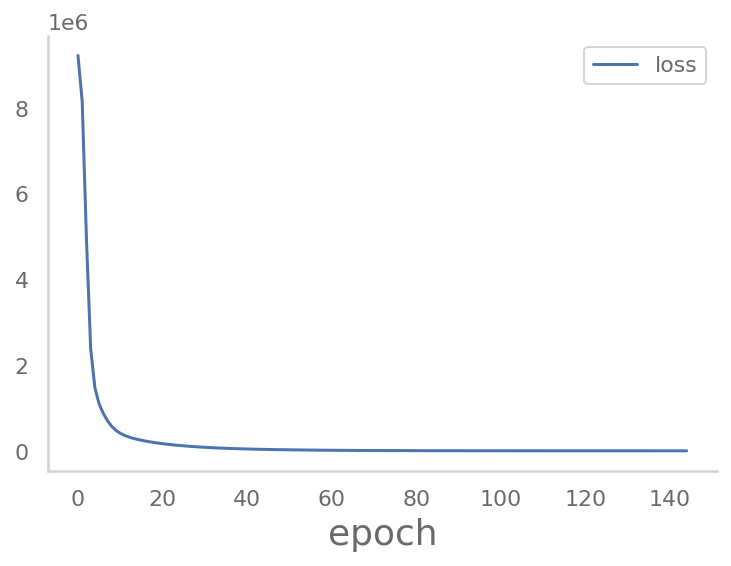

In [12]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.plot(x="epoch", y="loss")


In [16]:
test_results["dnn_model"] = dnn_model.evaluate(test_features, test_label)

print(test_results)


27/27 [==============================] - 0s 4ms/step - loss: 2057.9067 - mean_absolute_error: 25.1231
{'dnn_model': [2057.90673828125, 25.123111724853516]}


In [19]:
test_predictions = {}
test_predictions["dnn_model"] = dnn_model.predict(test_features).flatten()

test_predictions["dnn_model"]


array([3551.702 , 3462.9797, 3414.7336, 3470.9236, 3446.3584, 3471.3447,
       3419.6655, 3453.2136, 3412.074 , 3467.9883, 3691.132 , 3724.7253,
       3903.8704, 3895.437 , 3948.3796, 3916.393 , 3908.6091, 4023.2705,
       4099.585 , 4154.5825, 4109.9146, 4186.17  , 3989.5593, 3979.6204,
       3955.3474, 3951.6272, 4023.3525, 4185.945 , 4345.247 , 4331.047 ,
       4304.424 , 4248.0547, 4024.8076, 4084.5037, 4208.512 , 3941.9568,
       4003.2188, 3708.0212, 3777.985 , 3815.6814, 3822.8342, 3830.427 ,
       3944.314 , 4099.718 , 4110.829 , 4115.4565, 4057.434 , 3923.1365,
       3717.5576, 3811.654 , 3833.405 , 3654.6492, 3483.4587, 3463.4148,
       3294.3555, 3244.107 , 3209.8127, 3404.1587, 3265.181 , 3402.4497,
       3350.6096, 2947.43  , 2349.5396, 3342.3718, 2829.9192, 2835.5073,
       2574.3015, 2312.2478, 2658.3962, 2748.216 , 2931.6638, 2764.558 ,
       2465.4324, 2381.523 , 2301.7651, 2387.4924, 2308.383 , 2272.3062,
       2341.525 , 2365.518 , 2128.261 , 2020.8027, 

In [20]:
dtrain = xgb.DMatrix(train_features, label=train_label)
dtest = xgb.DMatrix(test_features, label=test_label)

param = {
    "max_depth": 100,
    "eta": 1,
    "objective": "reg:squarederror",
    "booster": "gbtree",
}
evallist = [(dtest, "eval"), (dtrain, "train")]

num_round = 2
xg = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-rmse:117.15534	train-rmse:112.49113
[1]	eval-rmse:23.53024	train-rmse:14.82329


In [15]:
# test_results["xgb"] = xg.evaluate(test_features, test_label)

# print(test_results)

In [22]:
test_predictions["xgb"] = xg.predict(dtest)

print(test_predictions["xgb"][:10])
print(test_label[:10])


[3512.4626 3473.9434 3399.9856 3502.756  3463.923  3485.9185 3457.068
 3473.9434 3399.9856 3485.9185]
time
2021-05-05 23:00:00    3524.948912
2021-05-06 02:00:00    3485.588006
2021-05-06 06:00:00    3396.217113
2021-05-06 11:00:00    3522.349910
2021-05-06 20:00:00    3466.452710
2021-05-06 23:00:00    3490.047376
2021-05-07 00:00:00    3497.831567
2021-05-07 01:00:00    3464.159632
2021-05-07 03:00:00    3430.588457
2021-05-07 21:00:00    3478.928705
Name: close, dtype: float64


In [23]:
def plot_result(labels, preds):
    plt.figure(figsize=(15, 10))
    plt.scatter(x=labels.index, y=labels, color="r", marker=".", label="real data")
    plt.scatter(x=labels.index, y=preds, color="b", marker="X", label="predictions")
    plt.xlabel("time")
    plt.ylabel("price")
    plt.title("Red is predictions, Blue is real data")
    plt.show()


findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


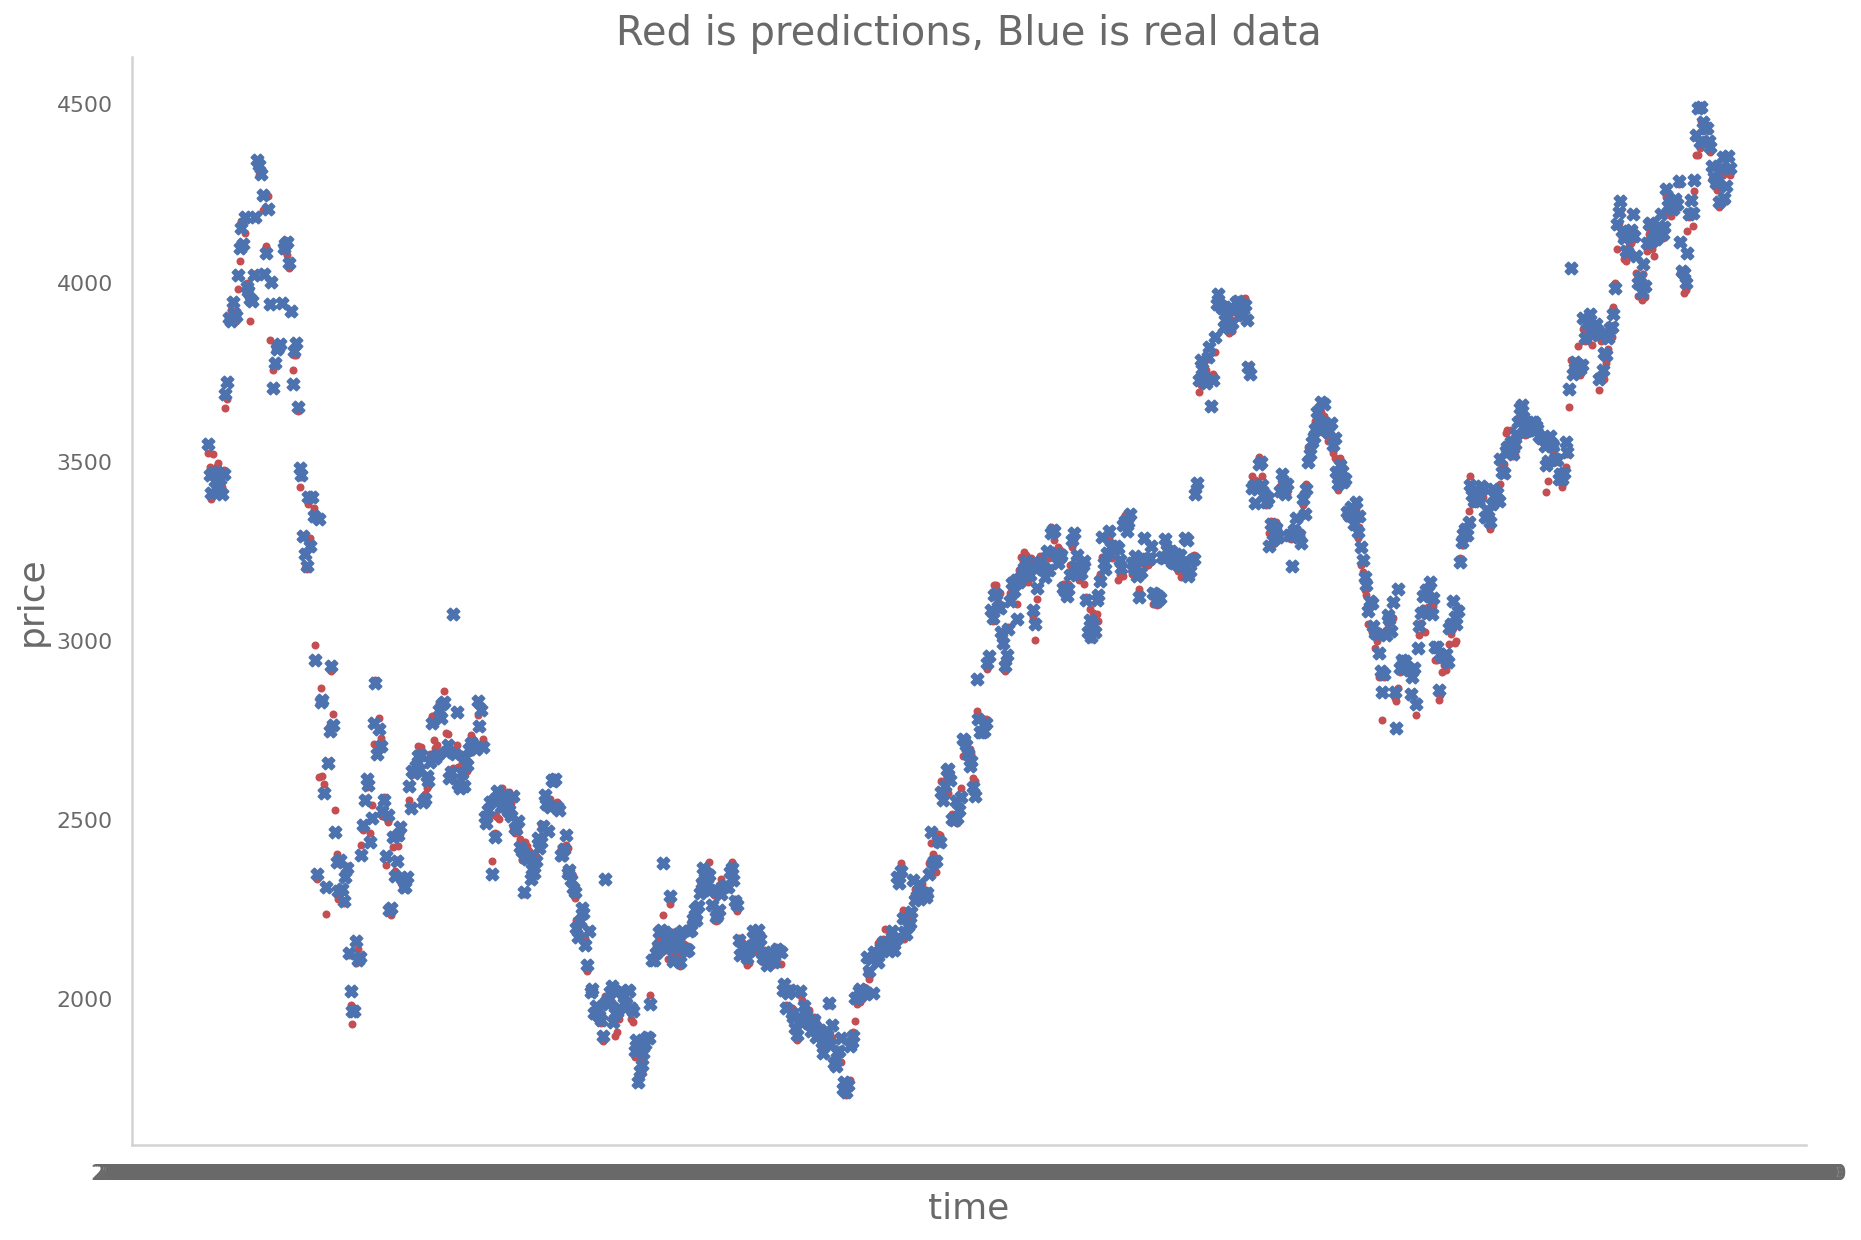

In [24]:
plot_result(test_label, test_predictions["dnn_model"])

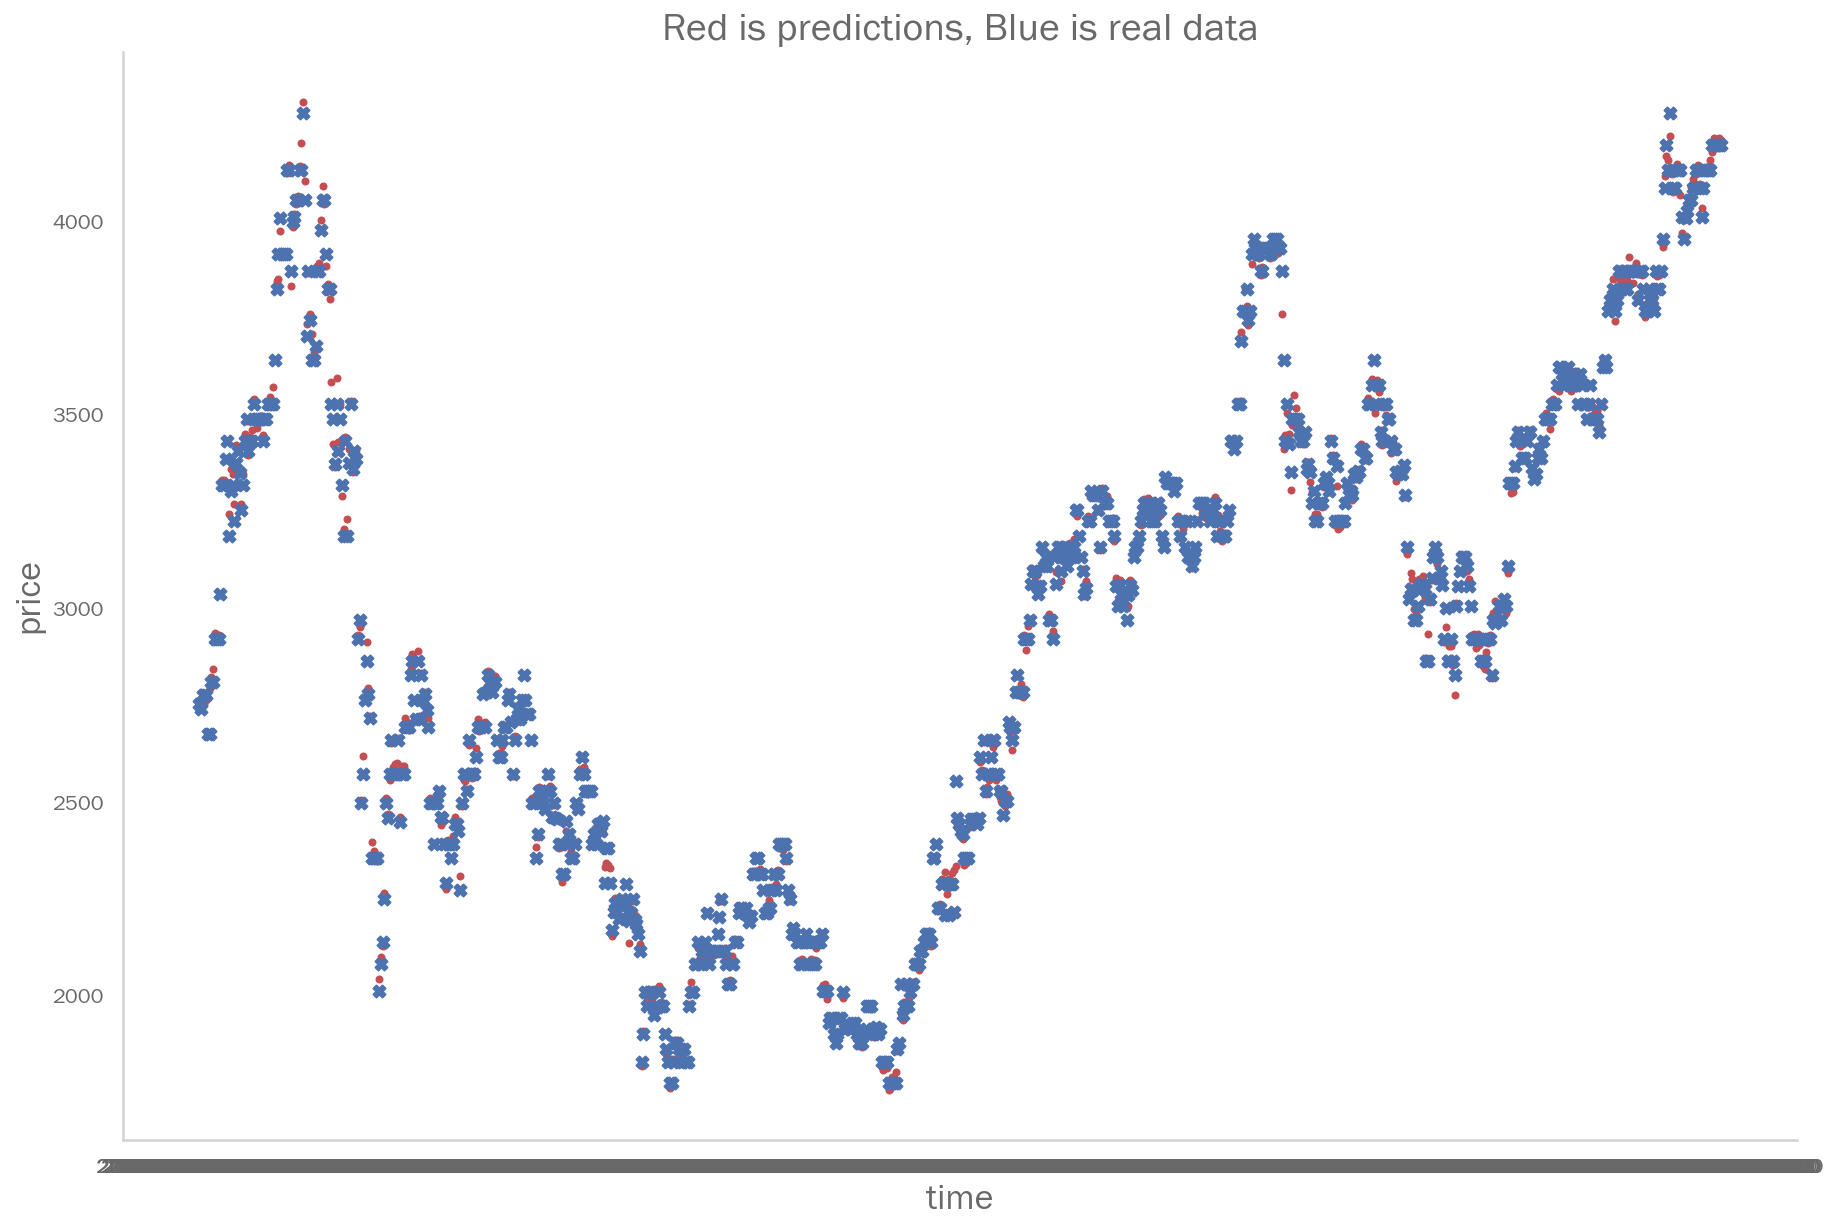

In [24]:
plot_result(test_label, test_predictions["xgb"])


In [57]:
newest = df[-2:]
new_label = newest.pop("close")
newest = xgb.DMatrix(newest, label=new_label)

In [60]:
xg.predict(newest)


array([4324.202, 4324.202], dtype=float32)

In [66]:
public_client.get_product_ticker(['ETH'])

{'message': 'NotFound'}